# **AN OPTIMIZED DEEP LEARNING MODEL FOR PREDICTING THE QUALITY OF A PORTUGUESE WHITE WINE USING ITS PHYSIOCHEMICAL PROPERTIES**

 # 1. **DATA LOADING AND EXPLORATION**

The first stage of the process invloves reading the file using the **pandas library** , and doing some basic data investigation using the .describe() method.



In [1]:
import pandas as pd
white_wine = pd.read_csv('../input/white-wine-quality/WhiteWineQualityCSV.csv')
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4890.000000,4891.000000,4896.000000,4896.000000,4896.000000,4898.000000,4898.000000,4898.000000,4891.000000,4896.000000,4898.000000,4898.000000
mean,6.855532,0.278252,0.334250,6.393250,0.045778,35.308085,138.360657,0.994027,3.188203,0.489835,10.514267,5.877909
std,0.843808,0.100811,0.120985,5.072275,0.021850,17.007137,42.498065,0.002991,0.151014,0.114147,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


It can be seen from the data description that our dataset contains **12 columns** and from the **count value** we can see that each column has varying . Some have 4890, 4891,4898 ,etc. Hence, we can infer that there are some missing values in certain places in our dataset. Hence, we will need to do some data preparation and preprocessing.

#  2. **Data Preparation, Splitting, Scaling and Choosing Target values**
   To solve the problem of missing values, we are going to solve the problem using the **SimpleImputer()method**  from the *sk.learn library*. To read more about how to handle missing values in a dataset, i will recommend you check out this lesson in one of  Kaggle's machine learning course https://www.kaggle.com/alexisbcook/missing-values.
   
   
*    **Splitting**
      
      In order to avoid overfitting , we are going to split the dataset into two parts - The training set and the validation set (also known as test set). I chose to have it in a ratio 70% to 30% , some people also like to have it as 80% to 20% . So either of these two ratios are fine.
       
*    **Scaling**    

       This is usually advised, because it enables most models to perform better with the dataset. So we scale our data to fit into [0,1].
     
*   **Choosing Target values**    

      Since we are trying to predict the quality of a white wine, given all it's physiochemical properties, we have to exclude it from the dataset and have it as our target value.

In [2]:
from sklearn.impute import SimpleImputer


# Create training and validation splits
df_train = white_wine.sample(frac=0.7, random_state=0)
df_valid = white_wine.drop(df_train.index)
display(df_train.head(4))

# Imputation
my_imputer = SimpleImputer()
imputed_df_train = pd.DataFrame(my_imputer.fit_transform(df_train))
imputed_df_valid = pd.DataFrame(my_imputer.transform(df_valid))

# Imputation removed column names; put them back
imputed_df_train.columns = df_train.columns
imputed_df_valid.columns = df_valid.columns

# Scale to [0, 1]
max_ = imputed_df_train.max(axis=0)
min_ = imputed_df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = imputed_df_train.drop('quality', axis=1)
X_valid = imputed_df_valid.drop('quality', axis=1)
y_train = imputed_df_train['quality']
y_valid = imputed_df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2762,7.3,0.32,0.35,1.4,0.050,8.0,163.0,0.99244,3.24,0.42,10.7,5
42,7.0,0.31,0.26,7.4,0.069,28.0,160.0,0.99540,3.13,0.46,9.8,6
1419,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7
3664,5.0,0.29,0.54,5.7,0.035,54.0,155.0,0.98976,3.27,0.34,12.9,8


In [3]:
X_train.shape # This helps us to find out the number of inputs in our Deep Learning network

(3429, 11)

# **3. Deploying a Deep Learning model using TensorFlow**

*  In this stage , we will be deploying a **3-layered deep learning network** from Keras and utilizing the **callbacks library** to apply **EarlyStopping method()** for obtaining an optimum value of weights , in order for us to minimise the validation loss.  

*  Also, we will compile our model by specifying the performance metric and our optimizer- which are **MEAN ABSOLUTE ERRROR(MAE)** and **ADAM** respectively 

In [4]:
from tensorflow import keras
from tensorflow.keras import layers,callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

# **4. Fitting of Model and Visualization of loss**

   In this stage, we will be fitting our model and viewing how our validation loss and in-dataset loss performs as we apply our earlystopping method()


Minimum validation loss: 0.5714572072029114


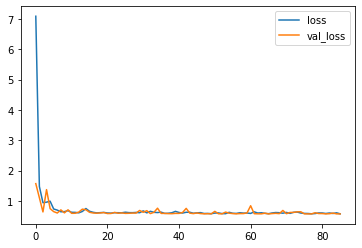

In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=600,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

From our Deep learning model, we obtained a loss of about 0.577

So we can say that on average that our predictions of a White Wine's quality using this model, will be about 0.577 above or below the exact value. It's not very ideal, and it's possible for us to still work on it and obtain better results. 

Thanks for reading. Do well to comment and leave questions below.